In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [5]:
#loading the csv data to a Pandas Dataframe
df = pd.read_csv('/content/Water_Quality_dataset.csv')

In [6]:
#printing first 5 rows of the dataframe
df.head()

,Well ID,S.No,STATE,DISTRICT,BLOCK,LOCATION,LATITUDE,LONGITUDE,Year,pH,...,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,W113126092431802,1,A&N Islands,South Andaman,PORT BLAIR,Kodiaghat,11.545,92.74583,2021,7.74,...,25.0,1.0,1.0,175.0,34.0,22.0,10.0,0.0,0.84,206.0
1,W113616092411001,2,A&N Islands,South Andaman,PORT BLAIR,Sippighat,11.6025,92.73,2021,7.53,...,82.0,5.0,1.0,250.0,52.0,29.0,51.0,1.0,0.28,381.0
2,W113640092443301,3,A&N Islands,South Andaman,PORT BLAIR,Brichganj,11.62083,92.73028,2021,7.50,...,35.0,1.0,0.0,125.0,4.0,28.0,10.0,1.0,0.46,151.0
3,W114421092422801,4,A&N Islands,South Andaman,FERRARGUNJ,Wimberleyganj,11.7325,92.70861,2021,7.60,...,39.0,2.0,0.0,135.0,26.0,17.0,15.0,2.0,0.37,198.0
4,W113955092391801,5,A&N Islands,South Andaman,FERRARGUNJ,Ograbraj,11.66361,92.65806,2021,7.82,...,560.0,56.0,5.0,465.0,56.0,79.0,336.0,18.0,0.95,1424.0


In [7]:
# Checking size of the dataset
df.shape

(5375, 23)

In [8]:
# Checking for datatypes of the dataset
df.dtypes

Well ID       object
S.No           int64
STATE         object
DISTRICT      object
BLOCK         object
LOCATION      object
LATITUDE      object
LONGITUDE     object
Year           int64
pH           float64
EC           float64
CO3          float64
HCO3         float64
Cl           float64
SO4          float64
NO3          float64
TH           float64
Ca           float64
Mg           float64
Na           float64
K            float64
F            float64
TDS          float64
dtype: object

# Converting object data type to numeric

In [9]:
def convert_to_numeric(df):
    num_col = df.shape[1]
    # Start from index 6
    for index in range(6, num_col):
        col_name = df.iloc[:, index].name
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
    return df

df = convert_to_numeric(df)
df.dtypes

Well ID       object
S.No           int64
STATE         object
DISTRICT      object
BLOCK         object
LOCATION      object
LATITUDE     float64
LONGITUDE    float64
Year           int64
pH           float64
EC           float64
CO3          float64
HCO3         float64
Cl           float64
SO4          float64
NO3          float64
TH           float64
Ca           float64
Mg           float64
Na           float64
K            float64
F            float64
TDS          float64
dtype: object

In [10]:
df.isnull().sum()

Well ID         0
S.No            0
STATE           0
DISTRICT        0
BLOCK          71
LOCATION        0
LATITUDE      811
LONGITUDE     810
Year            0
pH              0
EC              0
CO3             0
HCO3            0
Cl              0
SO4             1
NO3             0
TH              0
Ca              0
Mg              0
Na              0
K               1
F               0
TDS          2159
dtype: int64

# Handling null values

In [11]:
df['BLOCK'].fillna("not specified",inplace = True)
df['LATITUDE'].fillna(method='bfill', inplace=True)
df['LONGITUDE'].fillna(method='bfill', inplace=True)
# df['SO4'].fillna(method='bfill', inplace=True)
# df['K'].fillna(method='bfill', inplace=True)
df['SO4'].fillna(df.SO4.mean(), inplace=True)
df['K'].fillna(df.K.mean(), inplace=True)
df['TDS'].fillna(df.TDS.mean(), inplace=True)

In [12]:
df.isnull().sum()

Well ID      0
S.No         0
STATE        0
DISTRICT     0
BLOCK        0
LOCATION     0
LATITUDE     0
LONGITUDE    0
Year         0
pH           0
EC           0
CO3          0
HCO3         0
Cl           0
SO4          0
NO3          0
TH           0
Ca           0
Mg           0
Na           0
K            0
F            0
TDS          0
dtype: int64

# Set of parameters that are required to build predictive model

In [13]:
Required_parameters= df.drop(columns=["Well ID","S.No","Year","STATE","DISTRICT","BLOCK","LOCATION","LATITUDE","LONGITUDE"])

# Water Quality Index (WQI) Calculation

In [14]:
# Define Weight for each parameter
weights = {
    'pH': 0.10,    # Weight assigned to pH
    'EC': 0.12,    # Weight assigned to Electrical Conductivity
    'Cl': 0.08,    # Weight assigned to Chloride
    'TH': 0.10,    # Weight assigned to Total Hardness
    'Ca': 0.10,    # Weight assigned to Calcium
    'Mg': 0.10,    # Weight assigned to Magnesium
    'TDS': 0.15,   # Weight assigned to Total Dissolved Solids
    'HCO3': 0.08,  # Weight assigned to Bicarbonate
    'CO3': 0.07,   # Weight assigned to Carbonate
    'SO4': 0.08,   # Weight assigned to Sulfate
    'NO3': 0.05,   # Weight assigned to Nitrate
    'Na': 0.08,    # Weight assigned to Sodium
    'K': 0.07,     # Weight assigned to Potassium
    'F': 0.07      # Weight assigned to Fluoride
}

# Standard ranges for each parameter
standard_ranges = {
    'pH': [6.5, 8.5],   # pH level
    'EC': [50, 800],    # Electrical Conductivity (μS/cm)
    'Cl': [250, 600],   # Chloride (mg/L)
    'TH': [100, 300],   # Total Hardness (mg/L CaCO3)
    'Ca': [20, 120],    # Calcium (mg/L)
    'Mg': [10, 50],     # Magnesium (mg/L)
    'TDS': [300, 2000], # Total Dissolved Solids (mg/L)
    'HCO3': [0, 400],   # Bicarbonate (mg/L)
    'CO3': [0, 200],    # Carbonate (mg/L)
    'SO4': [0, 400],    # Sulfate (mg/L)
    'NO3': [0, 50],     # Nitrate (mg/L)
    'Na': [0, 200],     # Sodium (mg/L)
    'K': [0, 50],       # Potassium (mg/L)
    'F': [0, 2]         # Fluoride (mg/L)
}

# Create an empty list to store WQI values for each row
wqi_values = []

# Loop through each row
for index, row in Required_parameters.iterrows():

    # Initialize WQI for the current row
    wqi = 0

    # Loop through each parameter for the current row
    for param in Required_parameters.columns:
        # Calculate sub-index for the current parameter
        sub_index = 100 * (row[param] - standard_ranges[param][0]) / (standard_ranges[param][1] - standard_ranges[param][0])

        # Add to the WQI for the current row
        wqi += sub_index * weights[param]

    # Append the WQI value to the list
    wqi_values.append(wqi)

# Add the WQI values as a new column to the original DataFrame
df['WQI'] = wqi_values
#normalized_data['WQI']= wqi_values

# Display the DataFrame with WQI values
print(df)
#print(normalized_data)


               Well ID  S.No        STATE       DISTRICT       BLOCK  \
0     W113126092431802     1  A&N Islands  South Andaman  PORT BLAIR   
1     W113616092411001     2  A&N Islands  South Andaman  PORT BLAIR   
2     W113640092443301     3  A&N Islands  South Andaman  PORT BLAIR   
3     W114421092422801     4  A&N Islands  South Andaman  FERRARGUNJ   
4     W113955092391801     5  A&N Islands  South Andaman  FERRARGUNJ   
...                ...   ...          ...            ...         ...   
5370  W220500091040001  5371      Tripura  South Tripura    Satchand   
5371  W235602091511501  5372      Tripura         Dhalai     Ambassa   
5372  W230605091513506  5373      Tripura          Gomti       Killa   
5373  W240824092090501  5374      Tripura        Unakoti  Pecharthal   
5374  W232915091240601  5375      Tripura          Gomti  Kankra-ban   

           LOCATION   LATITUDE  LONGITUDE  Year    pH  ...    SO4   NO3  \
0         Kodiaghat  11.545000  92.745830  2021  7.74  ...  

# Multiclass

In [15]:
# 0-25  very bad
# 25-50 bad
# 50-70 Medium
# 70-90 Good
# 90-100 Excellent

# Multiclass Classification is used for more detailed results
df['Potability'] = df['WQI'].apply(lambda x: '0' if x < 25 else ('1' if x < 50 else ('2' if x < 70 else ('3' if x < 90 else '4'))))

# Display the DataFrame
print(df)

               Well ID  S.No        STATE       DISTRICT       BLOCK  \
0     W113126092431802     1  A&N Islands  South Andaman  PORT BLAIR   
1     W113616092411001     2  A&N Islands  South Andaman  PORT BLAIR   
2     W113640092443301     3  A&N Islands  South Andaman  PORT BLAIR   
3     W114421092422801     4  A&N Islands  South Andaman  FERRARGUNJ   
4     W113955092391801     5  A&N Islands  South Andaman  FERRARGUNJ   
...                ...   ...          ...            ...         ...   
5370  W220500091040001  5371      Tripura  South Tripura    Satchand   
5371  W235602091511501  5372      Tripura         Dhalai     Ambassa   
5372  W230605091513506  5373      Tripura          Gomti       Killa   
5373  W240824092090501  5374      Tripura        Unakoti  Pecharthal   
5374  W232915091240601  5375      Tripura          Gomti  Kankra-ban   

           LOCATION   LATITUDE  LONGITUDE  Year    pH  ...   NO3     TH  \
0         Kodiaghat  11.545000  92.745830  2021  7.74  ...  

In [16]:
df['Potability'].value_counts()

Potability
1    1656
0    1285
4    1046
2     859
3     529
Name: count, dtype: int64

# SMOTE

In [17]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assuming your data is stored in a pandas DataFrame called 'data'
# with the target variable named 'Potability'

# First, split your data into features (X) and target variable (y)
X = df[['pH','EC','CO3','HCO3','Cl','SO4','NO3','TH','Ca','Mg','Na','K','F','TDS']]
y = df['Potability']

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the resampled data
resampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Potability'])], axis=1)

# Now 'resampled_data' contains your balanced dataset


In [18]:
resampled_data

,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS,Potability
0,7.740000,349.000000,0.000000,183.000000,25.000000,1.000000,1.000000,175.000000,34.000000,22.000000,10.000000,0.000000,0.840000,206.000000,0
1,7.530000,660.000000,0.000000,262.000000,82.000000,5.000000,1.000000,250.000000,52.000000,29.000000,51.000000,1.000000,0.280000,381.000000,1
2,7.500000,270.000000,0.000000,116.000000,35.000000,1.000000,0.000000,125.000000,4.000000,28.000000,10.000000,1.000000,0.460000,151.000000,0
3,7.600000,311.000000,0.000000,159.000000,39.000000,2.000000,0.000000,135.000000,26.000000,17.000000,15.000000,2.000000,0.370000,198.000000,0
4,7.820000,2501.000000,0.000000,512.000000,560.000000,56.000000,5.000000,465.000000,56.000000,79.000000,336.000000,18.000000,0.950000,1424.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,7.570795,2094.867529,0.000000,231.240502,532.565208,101.629082,62.488663,859.578149,195.611420,89.894024,84.538714,0.685664,0.308145,1403.540769,4
8276,8.161114,2325.401762,0.000000,471.260977,486.923766,95.466264,41.375378,706.903223,38.046928,148.428147,221.000000,27.061581,0.992199,870.131197,4
8277,7.829427,2601.585846,0.000000,252.361161,523.339221,283.370050,147.788591,818.854635,90.748875,144.052880,232.259901,1.192068,0.628238,1740.317169,4
8278,8.699348,1314.802827,37.489399,407.204240,113.438339,127.575795,51.137455,338.468198,16.408480,72.387279,151.341695,54.739523,0.914737,865.880992,4


In [19]:
resampled_data['Potability'].value_counts()

Potability
0    1656
1    1656
4    1656
2    1656
3    1656
Name: count, dtype: int64

In [20]:
Required_parameters= resampled_data.drop(columns=["Potability"])

# Boxplot to view outliers

(8280, 14)

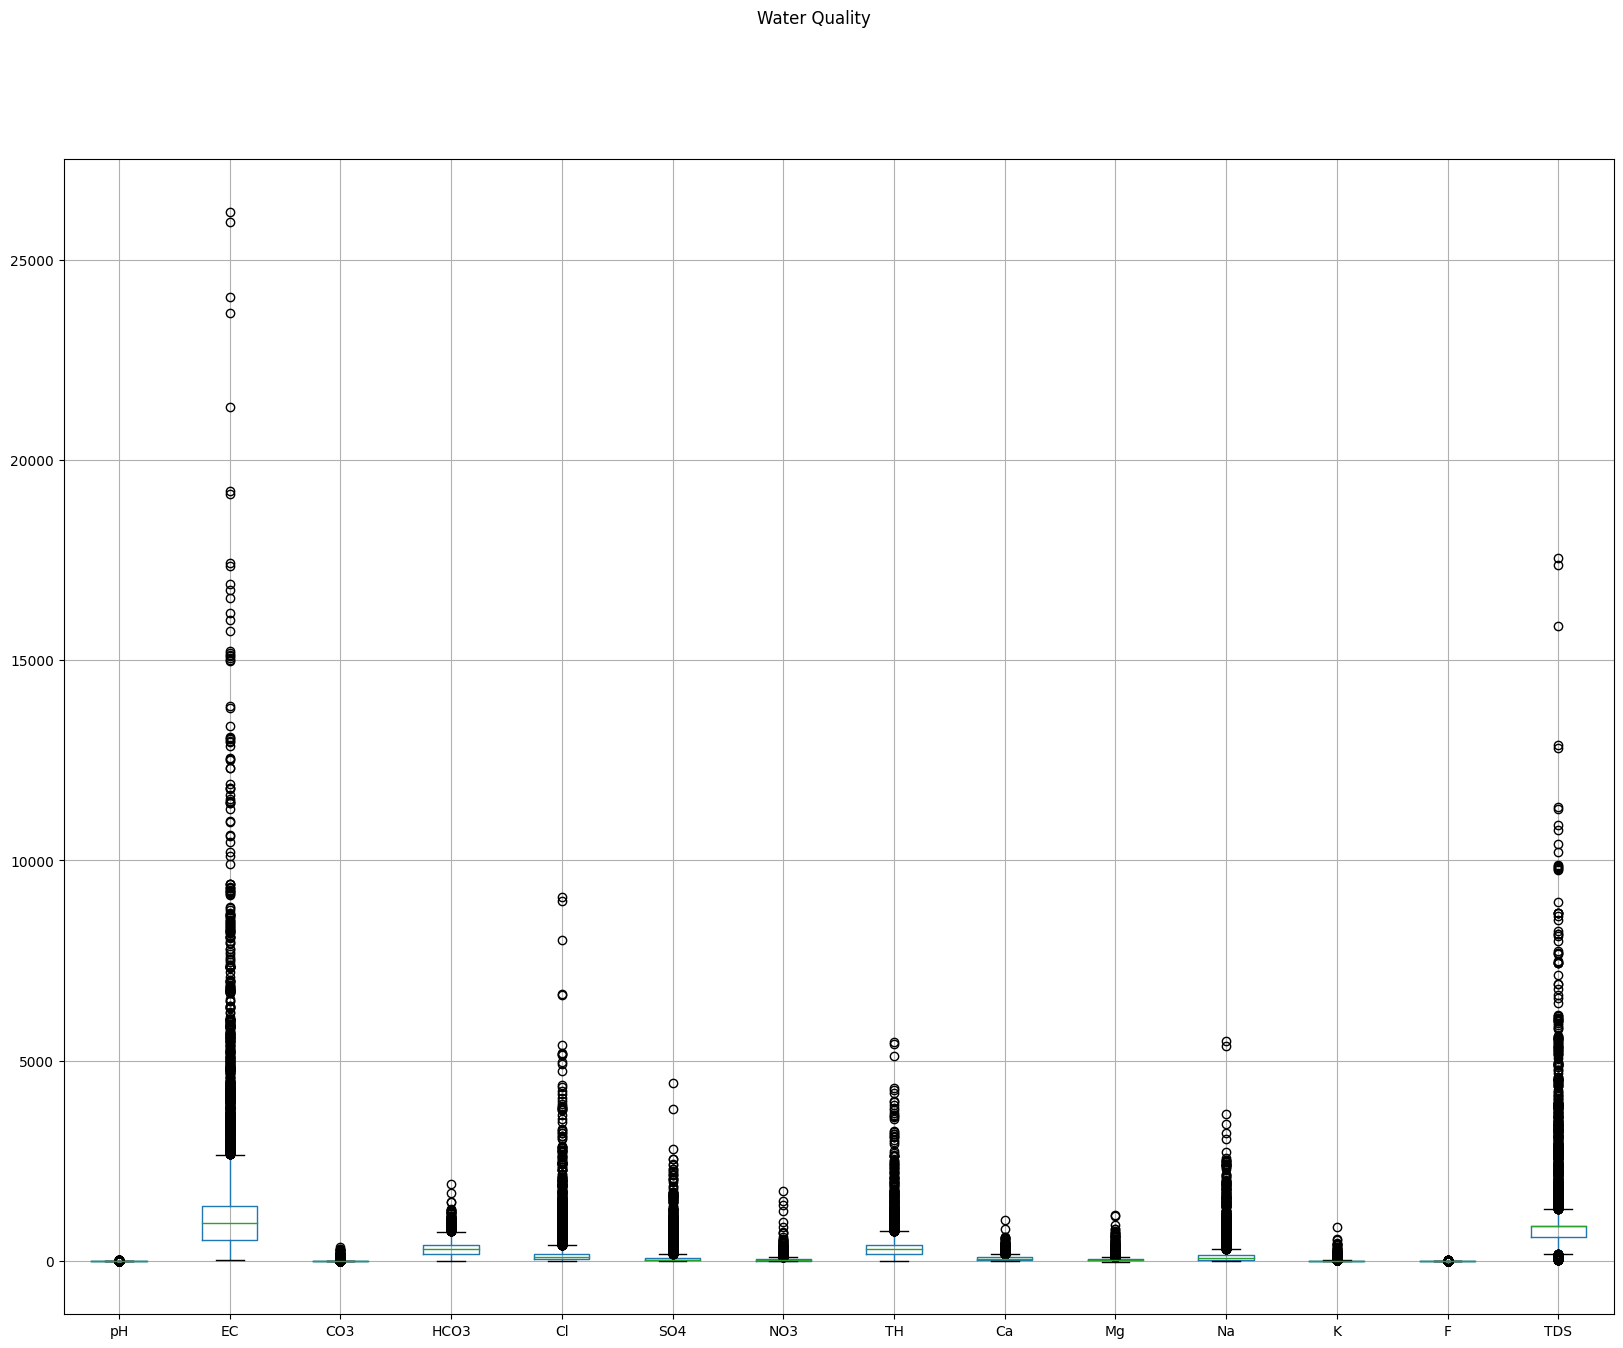

In [21]:
plt.figure(figsize=(20,15))
plt.suptitle("Water Quality")
ax = plt.gca()

Required_parameters.boxplot()
Required_parameters.shape

# Z-score For outlier Handling




Number of outliers using Z-Score method- 729


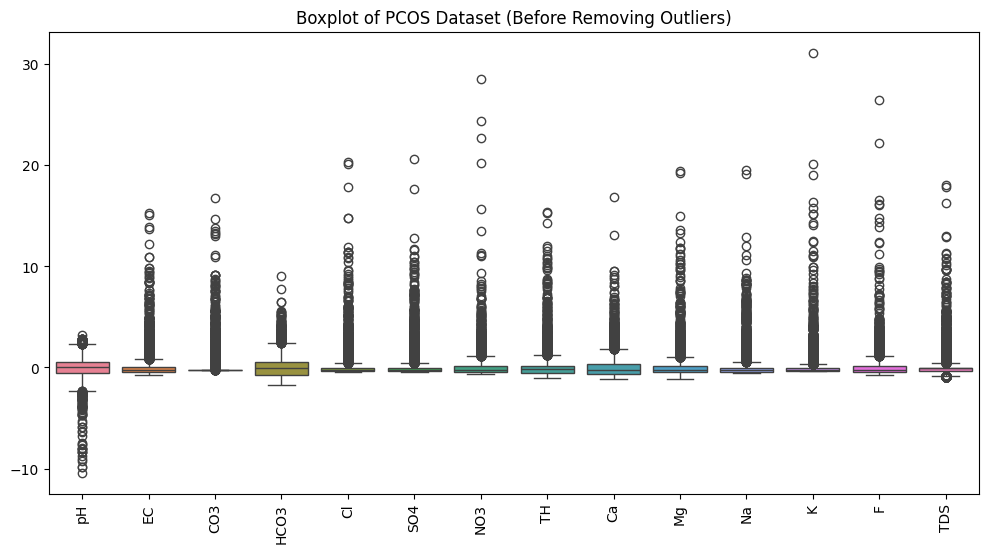

(8280, 14)

In [22]:
#remove outliner by z-score
from scipy import stats
# Here, almost all kde plots are Gaussian Like
# Using Z-Score Normalization to detect outliers
df_num_final = Required_parameters
df_final_norm = zscore(df_num_final, axis=0)


def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[: ,index]
        greater_than_3 = df_norm[col_index > 5]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_final_norm)
print("Number of outliers using Z-Score method-",len(indices_arr))
Required_parameters.iloc[indices_arr, :]


#Remove outliners using z-score
# Calculate Z-scores for each column
z_scores = stats.zscore(df_final_norm)

threshold = 3

# Identify and remove rows with Z-scores above the threshold
indices_arr = (abs(z_scores) > threshold).any(axis=1)
df_no_outliers = df_final_norm[~indices_arr]

# Print the resulting DataFrame without outliers
# print(df_no_outliers)

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(df_final_norm)
plt.title("Boxplot of PCOS Dataset (Before Removing Outliers)")
plt.xticks(rotation=90)
plt.show()

df_final_norm.shape

# Data Normalization

In [23]:
from sklearn.preprocessing import MinMaxScaler

min_range = 0
max_range = 1

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(min_range, max_range))

# Normalize the DataFrame
normalized_data = pd.DataFrame(scaler.fit_transform(df_final_norm), columns=df_final_norm.columns)

normalized_data

,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,0.756058,0.012297,0.000000,0.095561,0.002557,0.000226,0.000571,0.030947,0.031812,0.038827,0.001822,0.000000,0.037668,0.010862
1,0.722132,0.024180,0.000000,0.136815,0.008839,0.001129,0.000571,0.044714,0.049595,0.044866,0.009291,0.001186,0.012556,0.020840
2,0.717286,0.009279,0.000000,0.060574,0.003659,0.000226,0.000000,0.021770,0.002173,0.044003,0.001822,0.001186,0.020628,0.007726
3,0.733441,0.010846,0.000000,0.083029,0.004100,0.000451,0.000000,0.023605,0.023908,0.034513,0.002733,0.002372,0.016592,0.010406
4,0.768982,0.094520,0.000000,0.267363,0.061522,0.012641,0.002857,0.084178,0.053547,0.088007,0.061213,0.021352,0.042601,0.080310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,0.728723,0.079003,0.000000,0.120752,0.058498,0.022941,0.035708,0.156605,0.191475,0.097406,0.015401,0.000813,0.013818,0.079143
8276,0.824090,0.087811,0.000000,0.246089,0.053468,0.021550,0.023643,0.128581,0.035810,0.147910,0.040262,0.032102,0.044493,0.048729
8277,0.770505,0.098363,0.000000,0.131781,0.057481,0.063966,0.084451,0.149130,0.087877,0.144135,0.042314,0.001414,0.028172,0.098345
8278,0.911042,0.049198,0.107728,0.212639,0.012304,0.028798,0.029221,0.060953,0.014432,0.082301,0.027572,0.064934,0.041020,0.048487


#Feature Selection with Correlation Analysis

Feature Selection Method 1.Correlation Analysis

Highly Correlated features pairs:
('EC', 'Cl')
('EC', 'Na')
('Cl', 'Na')
('TH', 'Mg')


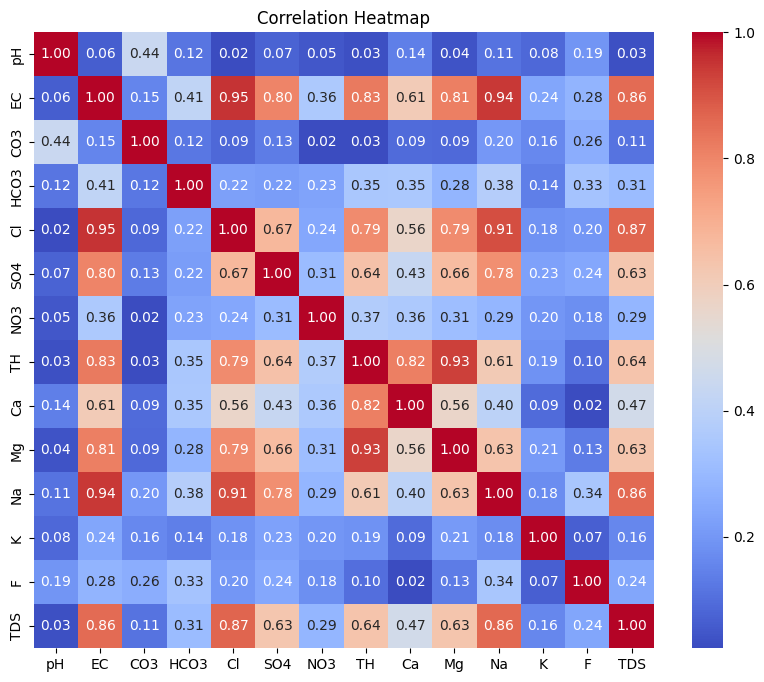

In [24]:
correlation_matrix = normalized_data.corr().abs()

threshold= 0.9

highly_correlated_pairs= []
for i in range(len(correlation_matrix.columns)):
  for j in range(i+1, len(correlation_matrix.columns)):
    if abs(correlation_matrix.iloc[i,j])> threshold:
      highly_correlated_pairs.append((correlation_matrix.columns[i],correlation_matrix.columns[j]))

print("Highly Correlated features pairs:")
for pair in highly_correlated_pairs:
  print(pair)

# Plotting correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [25]:
new_dataset_corr = normalized_data.drop(columns=['EC','Cl'])
new_dataset_corr

,pH,CO3,HCO3,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,0.756058,0.000000,0.095561,0.000226,0.000571,0.030947,0.031812,0.038827,0.001822,0.000000,0.037668,0.010862
1,0.722132,0.000000,0.136815,0.001129,0.000571,0.044714,0.049595,0.044866,0.009291,0.001186,0.012556,0.020840
2,0.717286,0.000000,0.060574,0.000226,0.000000,0.021770,0.002173,0.044003,0.001822,0.001186,0.020628,0.007726
3,0.733441,0.000000,0.083029,0.000451,0.000000,0.023605,0.023908,0.034513,0.002733,0.002372,0.016592,0.010406
4,0.768982,0.000000,0.267363,0.012641,0.002857,0.084178,0.053547,0.088007,0.061213,0.021352,0.042601,0.080310
...,...,...,...,...,...,...,...,...,...,...,...,...
8275,0.728723,0.000000,0.120752,0.022941,0.035708,0.156605,0.191475,0.097406,0.015401,0.000813,0.013818,0.079143
8276,0.824090,0.000000,0.246089,0.021550,0.023643,0.128581,0.035810,0.147910,0.040262,0.032102,0.044493,0.048729
8277,0.770505,0.000000,0.131781,0.063966,0.084451,0.149130,0.087877,0.144135,0.042314,0.001414,0.028172,0.098345
8278,0.911042,0.107728,0.212639,0.028798,0.029221,0.060953,0.014432,0.082301,0.027572,0.064934,0.041020,0.048487


In [26]:
new_dataset_corr.shape

(8280, 12)

# Correlation Analysis - Application of models based on these selected features

In [27]:
# Splitting the dataset into features (X) and target (y)
X_corr = new_dataset_corr
y_corr = resampled_data['Potability']
#y_corr = normalized_data['Potability']

In [28]:
new_dataset_corr.shape

(8280, 12)

In [29]:
# Splitting the dataset into the Training set and Test set
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(X_corr, y_corr, test_size=0.2, random_state=0)

In [30]:
y_train_corr = y_train_corr.astype(int)
y_test_corr = y_test_corr.astype(int)

In [31]:
ca_features_arr = X_test_corr.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]

# 1.Correlation Analysis - Logistic

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize the Logistic Regression Classifier
ca_lr_model = LogisticRegression()

# Training the Logistic Regression model with the training data
ca_lr_model.fit(X_train_corr, y_train_corr)

# Accuracy score on training data
ca_lr_X_train_pred = ca_lr_model.predict(X_train_corr)
ca_lr_training_data_accuracy = accuracy_score(y_train_corr, ca_lr_X_train_pred)

# Accuracy score on test data
ca_lr_X_test_pred = ca_lr_model.predict(X_test_corr)
ca_lr_test_data_accuracy = accuracy_score(y_test_corr, ca_lr_X_test_pred)

# Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
ca_lr_cv_scores = cross_val_score(ca_lr_model, ca_features_arr, y_test_corr, cv=5, scoring='accuracy')
ca_lr_cv_scores = np.mean(ca_lr_cv_scores)

# Precision score on test data
precision_lr = precision_score(y_test_corr, ca_lr_X_test_pred, average='weighted')

# Recall score on test data
recall_lr = recall_score(y_test_corr, ca_lr_X_test_pred, average='weighted')

# F1-score on test data
f1_lr = f1_score(y_test_corr, ca_lr_X_test_pred, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_lr = ca_lr_model.predict_proba(X_test_corr)

# ROC area under the curve score
roc_auc_lr = roc_auc_score(y_test_corr, y_probabilities_lr, average='weighted', multi_class='ovr')

print('-----------------------------------------------------------------------------------------------')
print('Accuracy score of training data while using Logistic Regression:', ca_lr_training_data_accuracy)
print('Accuracy score of testing data while using Logistic Regression:', ca_lr_test_data_accuracy)
print("Mean CV Score on testing data:", ca_lr_cv_scores)
print('Precision:', precision_lr)
print('Recall:', recall_lr)
print('F1-score:', f1_lr)
print('ROC area:', roc_auc_lr)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----------------------------------------------------------------------------------------------
Accuracy score of training data while using Logistic Regression: 0.7299214975845411
Accuracy score of testing data while using Logistic Regression: 0.7306763285024155
Mean CV Score on testing data: 0.6485585847923415
Precision: 0.7332395401163028
Recall: 0.7306763285024155
F1-score: 0.7262765003525516
ROC area: 0.9373681750958326


# 2.Correlation Analysis - Random forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize Random Forest and CA
ca_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust parameters as needed

# Training the Random Forest model with the training data
ca_rf_model.fit(X_train_corr, y_train_corr)

# Accuracy score on training data
ca_rf_X_train_pred = ca_rf_model.predict(X_train_corr)
ca_rf_training_data_accuracy = accuracy_score(y_train_corr, ca_rf_X_train_pred)

# Accuracy score on test data
ca_rf_X_test_pred = ca_rf_model.predict(X_test_corr)
ca_rf_test_data_accuracy = accuracy_score(y_test_corr, ca_rf_X_test_pred)

# Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
ca_rf_cv_scores = cross_val_score(ca_rf_model, ca_features_arr, y_test_corr, cv=5, scoring='accuracy')
ca_rf_cv_scores = np.mean(ca_rf_cv_scores)

# Precision score on test data
precision_rf = precision_score(y_test_corr, ca_rf_X_test_pred, average='weighted')

# Recall score on test data
recall_rf = recall_score(y_test_corr, ca_rf_X_test_pred, average='weighted')

# F1-score on test data
f1_rf = f1_score(y_test_corr, ca_rf_X_test_pred, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_rf = ca_rf_model.predict_proba(X_test_corr)

# ROC area under the curve score
roc_auc_rf = roc_auc_score(y_test_corr, y_probabilities_rf, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Random Forest:', ca_rf_training_data_accuracy)
print('Accuracy score of testing data while using Random Forest:', ca_rf_test_data_accuracy)
print("Mean CV Score on testing data:", ca_rf_cv_scores)
print('Precision:', precision_rf)
print('Recall:', recall_rf)
print('F1-score:', f1_rf)
print('ROC area:', roc_auc_rf)


Accuracy score of training data while using Random Forest: 1.0
Accuracy score of testing data while using Random Forest: 0.9486714975845411
Mean CV Score on testing data: 0.8925199286572271
Precision: 0.9486006436187834
Recall: 0.9486714975845411
F1-score: 0.9484777843244898
ROC area: 0.997037227161691


# 3.Correlation Analysis - SVM

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize the SVM Classifier
ca_svm_model = SVC(probability=True)  # Assuming you want probability estimates

# Training the SVM model with the training data
ca_svm_model.fit(X_train_corr, y_train_corr)

# Accuracy score on training data
ca_svm_X_train_pred = ca_svm_model.predict(X_train_corr)
ca_svm_training_data_accuracy = accuracy_score(y_train_corr, ca_svm_X_train_pred)

# Accuracy score on test data
ca_svm_X_test_pred = ca_svm_model.predict(X_test_corr)
ca_svm_test_data_accuracy = accuracy_score(y_test_corr, ca_svm_X_test_pred)

# Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
ca_svm_cv_scores = cross_val_score(ca_svm_model, ca_features_arr, y_test_corr, cv=5, scoring='accuracy')
ca_svm_cv_scores = np.mean(ca_svm_cv_scores)

# Precision score on test data
precision_svm = precision_score(y_test_corr, ca_svm_X_test_pred, average='weighted')

# Recall score on test data
recall_svm = recall_score(y_test_corr, ca_svm_X_test_pred, average='weighted')

# F1-score on test data
f1_svm = f1_score(y_test_corr, ca_svm_X_test_pred, average='weighted')

# Predict probabilities for ROC AUC
y_probabilities_svm = ca_svm_model.predict_proba(X_test_corr)

# ROC area under the curve score
roc_auc_svm = roc_auc_score(y_test_corr, y_probabilities_svm, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using SVM:', ca_svm_training_data_accuracy)
print('Accuracy score of testing data while using SVM:', ca_svm_test_data_accuracy)
print("Mean CV Score on testing data:", ca_svm_cv_scores)
print('Precision:', precision_svm)
print('Recall:', recall_svm)
print('F1-score:', f1_svm)
print('ROC area:', roc_auc_svm)


Accuracy score of training data while using SVM: 0.8570350241545893
Accuracy score of testing data while using SVM: 0.8792270531400966
Mean CV Score on testing data: 0.7385469369926838
Precision: 0.8838391944073118
Recall: 0.8792270531400966
F1-score: 0.8799895737387972
ROC area: 0.9880629237409733


# 4.Correlation Analysis - Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize Decision Tree Classifier
ca_dt_model = DecisionTreeClassifier(random_state=42)

# Training the Decision Tree model with the training data
ca_dt_model.fit(X_train_corr, y_train_corr)

# Accuracy score on training data
ca_dt_X_train_pred = ca_dt_model.predict(X_train_corr)
ca_dt_training_data_accuracy = accuracy_score(y_train_corr, ca_dt_X_train_pred)

# Accuracy score on test data
ca_dt_X_test_pred = ca_dt_model.predict(X_test_corr)
ca_dt_test_data_accuracy = accuracy_score(y_test_corr, ca_dt_X_test_pred)

# Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
ca_dt_cv_scores = cross_val_score(ca_dt_model, ca_features_arr, y_test_corr, cv=5, scoring='accuracy')
ca_dt_cv_scores = np.mean(ca_dt_cv_scores)

# Precision score on test data
precision_dt = precision_score(y_test_corr, ca_dt_X_test_pred, average='weighted')

# Recall score on test data
recall_dt = recall_score(y_test_corr, ca_dt_X_test_pred, average='weighted')

# F1-score on test data
f1_dt = f1_score(y_test_corr, ca_dt_X_test_pred, average='weighted')

# Predict probabilities for ROC AUC
y_probabilities_dt = ca_dt_model.predict_proba(X_test_corr)

# ROC area under the curve score
roc_auc_dt = roc_auc_score(y_test_corr, y_probabilities_dt, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Decision Tree:', ca_dt_training_data_accuracy)
print('Accuracy score of testing data while using Decision Tree:', ca_dt_test_data_accuracy)
print("Mean CV Score on testing data:", ca_dt_cv_scores)
print('Precision:', precision_dt)
print('Recall:', recall_dt)
print('F1-score:', f1_dt)
print('ROC area:', roc_auc_dt)


Accuracy score of training data while using Decision Tree: 1.0
Accuracy score of testing data while using Decision Tree: 0.8979468599033816
Mean CV Score on testing data: 0.8242783824118224
Precision: 0.8978965677184837
Recall: 0.8979468599033816
F1-score: 0.8973628949781428
ROC area: 0.9360994009744134


# 5.Correlation Analysis - XG Boost

In [36]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize XGBoost and RFE
ca_xgb_model = XGBClassifier(n_estimators=100, random_state=42)

# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
y_train_corr = label_encoder.fit_transform(y_train_corr)

# Training the Logistic Regression model with the training data
ca_xgb_model.fit(X_train_corr, y_train_corr)

# Accuracy score on training data
ca_xgb_X_train_pred = ca_xgb_model.predict(X_train_corr)
ca_xgb_training_data_accuracy = accuracy_score(y_train_corr, ca_xgb_X_train_pred)

# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
y_test_corr = label_encoder.fit_transform(y_test_corr)

# Accuracy score on test data
ca_xgb_X_test_pred = ca_xgb_model.predict(X_test_corr)
ca_xgb_test_data_accuracy = accuracy_score(y_test_corr, ca_xgb_X_test_pred)

# :Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
ca_xgb_cv_scores = cross_val_score(ca_xgb_model, ca_features_arr, y_test_corr, cv=5, scoring='accuracy')
ca_xgb_cv_scores=np.mean(ca_xgb_cv_scores)

# Precision score on test data
ca_precision_xgb = precision_score(y_test_corr, ca_xgb_X_test_pred, average='weighted')

# Recall score on test data
ca_recall_xgb = recall_score(y_test_corr, ca_xgb_X_test_pred, average='weighted')

# F1-score on test data
ca_f1_xgb = f1_score(y_test_corr, ca_xgb_X_test_pred, average='weighted')

# Predict probabilities for ROC AUC
y_probabilities_xgb = ca_xgb_model.predict_proba(X_test_corr)

# ROC area under the curve score
ca_roc_auc_xgb = roc_auc_score(y_test_corr, y_probabilities_xgb, average='weighted', multi_class='ovr')


print('Accuracy score of training data while using Logistic Regression: ', ca_xgb_training_data_accuracy)
print('Accuracy score of testing data while using Logistic Regression: ', ca_xgb_test_data_accuracy)
print("Mean CV Score on testing data:", np.mean(ca_xgb_cv_scores))
print('Precision:', ca_precision_xgb)
print('Recall:', ca_recall_xgb)
print('F1-score:', ca_f1_xgb)
print('ROC area:', ca_roc_auc_xgb)

Accuracy score of training data while using Logistic Regression:  1.0
Accuracy score of testing data while using Logistic Regression:  0.966183574879227
Mean CV Score on testing data: 0.9058038801732611
Precision: 0.9662119874006748
Recall: 0.966183574879227
F1-score: 0.966135523865727
ROC area: 0.9975956888738561


# 6.Correlation Analysis - KNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize KNN Classifier
ca_knn_model = KNeighborsClassifier()

# Training the KNN model with the training data
ca_knn_model.fit(X_train_corr, y_train_corr)

# Accuracy score on training data
ca_knn_X_train_pred = ca_knn_model.predict(X_train_corr)
ca_knn_training_data_accuracy = accuracy_score(y_train_corr, ca_knn_X_train_pred)

# Accuracy score on test data
ca_knn_X_test_pred = ca_knn_model.predict(X_test_corr)
ca_knn_test_data_accuracy = accuracy_score(y_test_corr, ca_knn_X_test_pred)

# Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
ca_knn_cv_scores = cross_val_score(ca_knn_model, ca_features_arr, y_test_corr, cv=5, scoring='accuracy')
ca_knn_cv_scores = np.mean(ca_knn_cv_scores)

# Precision score on test data
ca_precision_knn = precision_score(y_test_corr, ca_knn_X_test_pred, average='weighted')

# Recall score on test data
ca_recall_knn = recall_score(y_test_corr, ca_knn_X_test_pred, average='weighted')

# F1-score on test data
ca_f1_knn = f1_score(y_test_corr, ca_knn_X_test_pred, average='weighted')

# Predict probabilities for ROC AUC
y_probabilities_knn = ca_knn_model.predict_proba(X_test_corr)

# ROC area under the curve score
ca_roc_auc_knn = roc_auc_score(y_test_corr, y_probabilities_knn, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using KNN:', ca_knn_training_data_accuracy)
print('Accuracy score of testing data while using KNN:', ca_knn_test_data_accuracy)
print("Mean CV Score on testing data:", ca_knn_cv_scores)
print('Precision:', ca_precision_knn)
print('Recall:', ca_recall_knn)
print('F1-score:', ca_f1_knn)
print('ROC area:', ca_roc_auc_knn)


Accuracy score of training data while using KNN: 0.9073067632850241
Accuracy score of testing data while using KNN: 0.842391304347826
Mean CV Score on testing data: 0.7518199686965384
Precision: 0.8468146912811342
Recall: 0.842391304347826
F1-score: 0.8423963820778414
ROC area: 0.967995268313711


# 7.Correlation Analysis - Gradient boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize Gradient Boosting Classifier
ca_gb_model = GradientBoostingClassifier()

# Training the Gradient Boosting model with the training data
ca_gb_model.fit(X_train_corr, y_train_corr)

# Accuracy score on training data
ca_gb_X_train_pred = ca_gb_model.predict(X_train_corr)
ca_gb_training_data_accuracy = accuracy_score(y_train_corr, ca_gb_X_train_pred)

# Accuracy score on test data
ca_gb_X_test_pred = ca_gb_model.predict(X_test_corr)
ca_gb_test_data_accuracy = accuracy_score(y_test_corr, ca_gb_X_test_pred)

# Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
ca_gb_cv_scores = cross_val_score(ca_gb_model, ca_features_arr, y_test_corr, cv=5, scoring='accuracy')
ca_gb_cv_scores = np.mean(ca_gb_cv_scores)

# Precision score on test data
precision_gb = precision_score(y_test_corr, ca_gb_X_test_pred, average='weighted')

# Recall score on test data
recall_gb = recall_score(y_test_corr, ca_gb_X_test_pred, average='weighted')

# F1-score on test data
f1_gb = f1_score(y_test_corr, ca_gb_X_test_pred, average='weighted')

# Predict probabilities for ROC AUC
y_probabilities_gb = ca_gb_model.predict_proba(X_test_corr)

# ROC area under the curve score
roc_auc_gb = roc_auc_score(y_test_corr, y_probabilities_gb, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Gradient Boosting:', ca_gb_training_data_accuracy)
print('Accuracy score of testing data while using Gradient Boosting:', ca_gb_test_data_accuracy)
print("Mean CV Score on testing data:", ca_gb_cv_scores)
print('Precision:', precision_gb)
print('Recall:', recall_gb)
print('F1-score:', f1_gb)
print('ROC area:', roc_auc_gb)


# 8.Correlation Analysis - MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize MLP Classifier
ca_mlp_model = MLPClassifier()

# Training the MLP model with the training data
ca_mlp_model.fit(X_train_corr, y_train_corr)

# Accuracy score on training data
ca_mlp_X_train_pred = ca_mlp_model.predict(X_train_corr)
ca_mlp_training_data_accuracy = accuracy_score(y_train_corr, ca_mlp_X_train_pred)

# Accuracy score on test data
ca_mlp_X_test_pred = ca_mlp_model.predict(X_test_corr)
ca_mlp_test_data_accuracy = accuracy_score(y_test_corr, ca_mlp_X_test_pred)

# Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
ca_mlp_cv_scores = cross_val_score(ca_mlp_model, ca_features_arr, y_test_corr, cv=5, scoring='accuracy')
ca_mlp_cv_scores = np.mean(ca_mlp_cv_scores)

# Precision score on test data
precision_mlp = precision_score(y_test_corr, ca_mlp_X_test_pred, average='weighted')

# Recall score on test data
recall_mlp = recall_score(y_test_corr, ca_mlp_X_test_pred, average='weighted')

# F1-score on test data
f1_mlp = f1_score(y_test_corr, ca_mlp_X_test_pred, average='weighted')

# Predict probabilities for ROC AUC
y_probabilities_mlp = ca_mlp_model.predict_proba(X_test_corr)

# ROC area under the curve score
roc_auc_mlp = roc_auc_score(y_test_corr, y_probabilities_mlp, average='weighted', multi_class='ovr')

print('-----------------------------------------------------------------------------------------------')
print('Accuracy score of training data while using MLP:', ca_mlp_training_data_accuracy)
print('Accuracy score of testing data while using MLP:', ca_mlp_test_data_accuracy)
print("Mean CV Score on testing data:", ca_mlp_cv_scores)
print('Precision:', precision_mlp)
print('Recall:', recall_mlp)
print('F1-score:', f1_mlp)
print('ROC area:', roc_auc_mlp)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

-----------------------------------------------------------------------------------------------
Accuracy score of training data while using MLP: 0.9601449275362319
Accuracy score of testing data while using MLP: 0.9589371980676329
Mean CV Score on testing data: 0.8737979106759365
Precision: 0.9591402897299587
Recall: 0.9589371980676329
F1-score: 0.9589131115694796
ROC area: 0.9979269496737989


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Accuracy Plots

#Stacking

In [43]:
# Define estimators
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimator_list = [
    ('lr',ca_lr_model),
    ('rf',ca_rf_model),
    ('svm', ca_svm_model),
    ('dt',ca_dt_model),
    ('XGB',ca_xgb_model),
    ('knn',ca_knn_model),

      ]

# Build stack model
ca_stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator= KNeighborsClassifier()
)

# Train stacked model
ca_stack_model.fit(X_train_corr, y_train_corr)

# Make predictions
ca_y_train_pred_stack = ca_stack_model.predict(X_train_corr)
ca_y_test_pred_stack = ca_stack_model.predict(X_test_corr)

# Training set model performance
ca_stack_model_train_accuracy = accuracy_score(y_train_corr, ca_y_train_pred_stack)
print('Training Accuracy: %s' % ca_stack_model_train_accuracy)

# Test set model performance
ca_stack_model_test_accuracy = accuracy_score(y_test_corr, ca_y_test_pred_stack)
print('Testing Accuracy: %s' % ca_stack_model_test_accuracy)

# Perform cross-validation on testing dataset
ca_stack_cv_scores = cross_val_score(ca_stack_model, ca_features_arr, y_test_corr, cv=5, scoring='accuracy')
ca_stack_cv_scores = np.mean(ca_stack_cv_scores)

#Precision score on test data
ca_precision_stack = precision_score(y_test_corr, ca_y_test_pred_stack, average='weighted')

# Recall score on test data
ca_recall_stack = recall_score(y_test_corr, ca_y_test_pred_stack, average='weighted')

# F1-score on test data
ca_f1_stack = f1_score(y_test_corr, ca_y_test_pred_stack, average='weighted')

# Predict probabilities for ROC AUC
ca_y_probabilities_stack = ca_stack_model.predict_proba(X_test_corr)

# ROC area under the curve score
ca_roc_auc_stack = roc_auc_score(y_test_corr, ca_y_probabilities_stack, average='weighted', multi_class='ovr')

print("Mean CV Score on testing data:", ca_stack_cv_scores)
print('Precision:', ca_precision_stack)
print('Recall:', ca_recall_stack)
print('F1-score:', ca_f1_stack)
print('ROC area:', ca_roc_auc_stack)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training Accuracy: 0.9984903381642513
Testing Accuracy: 0.9607487922705314
Mean CV Score on testing data: 0.9039784515706331
Precision: 0.960678566345475
Recall: 0.9607487922705314
F1-score: 0.9607018640584877
ROC area: 0.9926188200187129


# Correlation - Hyperparameter tunning

In [ ]:
X_corr_hy = new_dataset_corr
y_corr_hy = resampled_data['Potability']
#y_corr_hy = normalized_data['Potability']

# Splitting the dataset into the Training set and Test set
X_corr_hy_train, X_corr_hy_test, y_corr_hy_train, y_corr_hy_test = train_test_split(X_corr_hy, y_corr_hy, test_size=0.2, random_state=42)

# Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2'],          # Regularization penalty
    'C': [0.001, 0.01, 0.1, 1, 10],   # Inverse of regularization strength
    'solver': ['liblinear', 'saga']   # Solver algorithm
}

# Initialize GridSearchCV
grid_lr = GridSearchCV(ca_lr_model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_lr.fit(X_corr_hy_train,y_corr_hy_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_lr.best_params_)

# Get the best model
print(grid_lr.best_score_)
print(grid_lr.best_estimator_)

# Make predictions on the testing set using the best model
predictionforest = grid_lr.best_estimator_.predict(X_corr_hy_test)

# Train accuracy
y_train_pred = grid_lr.best_estimator_.predict(X_corr_hy_train)
ca_lr_training_data_accuracy_hy = accuracy_score(y_corr_hy_train, y_train_pred)
print("Training accuracy:", ca_lr_training_data_accuracy_hy)

# Fit the LogisticRegression model with training data
ca_lr_model.fit(X_corr_hy_train, y_corr_hy_train)

# Predict probabilities for the test data
y_pred1 = ca_lr_model.predict_proba(X_corr_hy_test)

# labels for set 1=True to upper left and 0 = False to lower right
print ("{0}".format(metrics.classification_report(y_corr_hy_test, predictionforest, labels=[1, 0])))
ca_lr_test_data_accuracy_hy = accuracy_score(y_corr_hy_test,predictionforest)
print ("testing accuracy: ",ca_lr_test_data_accuracy_hy)

# Perform cross-validation on testing dataset
ca_lr_cv_scores_hy = cross_val_score(grid_lr, ca_features_arr, y_corr_hy_test, cv=5, scoring='accuracy')
ca_lr_cv_scores_hy = np.mean(ca_lr_cv_scores_hy)

# Precision score on test data
precision_lr_hy = precision_score(y_corr_hy_test, predictionforest, average='weighted')

# Recall score on test data
recall_lr_hy = recall_score(y_corr_hy_test, predictionforest, average='weighted')

# F1-score on test data
f1_lr_hy = f1_score(y_corr_hy_test, predictionforest, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_lr_hy = grid_lr.predict_proba(X_corr_hy_test)

# ROC area under the curve score
roc_auc_lr_hy = roc_auc_score(y_corr_hy_test, y_probabilities_lr, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Logistic Regression:', ca_lr_training_data_accuracy_hy)
print('Accuracy score of testing data while using Logistic Regression:', ca_lr_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ca_lr_cv_scores_hy)
print('Precision:', precision_lr_hy)
print('Recall:', recall_lr_hy)
print('F1-score:', f1_lr_hy)
print('ROC area:', roc_auc_lr_hy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
0.8953794675939122
LogisticRegression(C=10, penalty='l1', solver='saga')
Training accuracy: 0.9067028985507246


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           1       0.89      0.83      0.86       344
           0       0.91      0.93      0.92       307

   micro avg       0.90      0.88      0.89       651
   macro avg       0.90      0.88      0.89       651
weighted avg       0.90      0.88      0.89       651

testing accuracy:  0.8979468599033816


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Accuracy score of training data while using Logistic Regression: 0.9067028985507246
Accuracy score of testing data while using Logistic Regression: 0.8979468599033816
Mean CV Score on testing data: 0.20410402941069417
Precision: 0.9007728314866581
Recall: 0.8979468599033816
F1-score: 0.8981530537343804
ROC area: 0.5139844241509554


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Instantiate Random Forest model
ca_rf_model = RandomForestClassifier()

# Specify parameters for Random Forest
n_estimators_values = [50, 100, 150]
max_depth_values = [None, 10, 20, 30]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

param_grid_rf = {
    'n_estimators': n_estimators_values,
    'max_depth': max_depth_values,
    'min_samples_split': min_samples_split_values,
    'min_samples_leaf': min_samples_leaf_values
}

# Perform Grid Search Cross-Validation
grid_rf = GridSearchCV(ca_rf_model, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_corr_hy_train, y_corr_hy_train)

# Print best parameters, best score, and best estimator
print("Best Parameters: ", grid_rf.best_params_)
print("Best Accuracy Score: ", grid_rf.best_score_)
print("Best Estimator: ", grid_rf.best_estimator_)

# Train accuracy
y_train_pred = grid_rf.best_estimator_.predict(X_corr_hy_train)
ca_rf_training_data_accuracy_hy = accuracy_score(y_corr_hy_train, y_train_pred)
print("Training accuracy:", ca_rf_training_data_accuracy_hy)

# Make predictions using the best model
prediction_rf = grid_rf.best_estimator_.predict(X_corr_hy_test)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_corr_hy_test, prediction_rf))
print("Classification Report:\n", classification_report(y_corr_hy_test, prediction_rf, labels=[1, 0]))

# Print accuracy score
ca_rf_test_data_accuracy_hy = accuracy_score(y_corr_hy_test, prediction_rf)
print("Accuracy: ", ca_rf_test_data_accuracy_hy)

# Precision score on test data
precision_rf_hy = precision_score(y_corr_hy_test, prediction_rf, average='weighted')

# Recall score on test data
recall_rf_hy = recall_score(y_corr_hy_test, prediction_rf, average='weighted')

# F1-score on test data
f1_rf_hy = f1_score(y_corr_hy_test, prediction_rf, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_rf_hy = grid_rf.best_estimator_.predict_proba(X_corr_hy_test)

# ROC area under the curve score
roc_auc_rf_hy = roc_auc_score(y_corr_hy_test, y_probabilities_rf_hy, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Random Forest:', ca_rf_training_data_accuracy_hy)
print('Accuracy score of testing data while using Random Forest:', ca_rf_test_data_accuracy_hy)
print('Precision:', precision_rf_hy)
print('Recall:', recall_rf_hy)
print('F1-score:', f1_rf_hy)
print('ROC area:', roc_auc_rf_hy)


Best Parameters:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Accuracy Score:  0.9430867012483611
Best Estimator:  RandomForestClassifier(max_depth=30, n_estimators=150)
Training accuracy: 1.0
Confusion Matrix:
 [[297  10   0   0   0]
 [ 20 308  16   0   0]
 [  1  10 318  13   0]
 [  0   0   3 330   3]
 [  0   0   0  10 317]]
Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.90      0.92       344
           0       0.93      0.97      0.95       307

   micro avg       0.94      0.93      0.93       651
   macro avg       0.94      0.93      0.93       651
weighted avg       0.94      0.93      0.93       651

Accuracy:  0.9480676328502415
Accuracy score of training data while using Random Forest: 1.0
Accuracy score of testing data while using Random Forest: 0.9480676328502415
Precision: 0.9483761654309555
Recall: 0.9480676328502415
F1-score: 0.9479077612165591
ROC area: 0.996645

In [ ]:
# Perform Grid Search Cross-Validation
grid_rf = GridSearchCV(ca_rf_model, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_corr_hy_train, y_corr_hy_train)

# Print cross-validation scores
print("Cross-Validation Scores:", grid_rf.cv_results_['mean_test_score'])


Cross-Validation Scores: [0.9375002  0.94097213 0.94278424 0.93538642 0.9384062  0.94293473
 0.93402805 0.93719797 0.93598985 0.93599111 0.93870797 0.9378022
 0.9376516  0.93538699 0.93734971 0.92934777 0.93327264 0.93508499
 0.929348   0.93206544 0.93206555 0.92904555 0.93161341 0.9329711
 0.92798974 0.92964989 0.93116012 0.92119501 0.92225161 0.92421433
 0.92225195 0.92013783 0.92512102 0.91817625 0.92104532 0.92195075
 0.92029026 0.91998735 0.92300724 0.91832663 0.92361113 0.9231583
 0.91696848 0.91983709 0.92225275 0.91228764 0.91832685 0.92119558
 0.91802577 0.91757248 0.92074332 0.91666636 0.91893131 0.91938403
 0.93976424 0.94127492 0.93931198 0.93629174 0.93931163 0.93855658
 0.93297178 0.93478276 0.93599031 0.93719797 0.93900986 0.93901009
 0.93553759 0.93599054 0.93900884 0.93312227 0.93417876 0.93327333
 0.93040506 0.93085823 0.93236755 0.92814034 0.92844257 0.93191518
 0.92753668 0.93085801 0.93116023 0.9409727  0.94293519 0.94097235
 0.93870763 0.94052009 0.93976435 0.9352

# Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Specify parameters for SVM
C_values = [0.1, 1, 10,100]
kernel_values = ['linear', 'rbf', 'sigmoid']
gamma_values = ['scale', 'auto', 0.1, 0.01]

param_grid_svm = {
    'C': C_values,
    'kernel': kernel_values,
    'gamma': gamma_values
}

# Perform Grid Search Cross-Validation
grid_svm = GridSearchCV(ca_svm_model, param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_corr_hy_train, y_corr_hy_train)

# Print best parameters, best score, and best estimator
print("Best Parameters: ", grid_svm.best_params_)
print("Best Training Accuracy Score: ", grid_svm.best_score_)
print("Best Estimator: ", grid_svm.best_estimator_)

# Train accuracy
y_train_pred = grid_svm.best_estimator_.predict(X_corr_hy_train)
ca_svm_training_data_accuracy_hy = accuracy_score(y_corr_hy_train, y_train_pred)
print("Training accuracy:", ca_svm_training_data_accuracy_hy)

# Make predictions using the best model
prediction_svm = grid_svm.best_estimator_.predict(X_corr_hy_test)
y_pred_svm = grid_svm.best_estimator_.predict_proba(X_corr_hy_test)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_corr_hy_test, prediction_svm))
print("Classification Report:\n", classification_report(y_corr_hy_test, prediction_svm, labels=[1, 0]))

# # Print accuracy and ROC AUC scores
ca_svm_test_data_accuracy_hy = accuracy_score(y_corr_hy_test, prediction_svm)
print("Training Accuracy: ", ca_svm_test_data_accuracy_hy)

# Perform cross-validation on testing dataset
# ca_svm_cv_scores_hy = cross_val_score(grid_svm, ca_features_arr, y_corr_hy_test, cv=5, scoring='accuracy')
# ca_svm_cv_scores_hy = np.mean(ca_svm_cv_scores_hy)

# Precision score on test data
precision_svm_hy = precision_score(y_corr_hy_test, predictionforest, average='weighted')

# Recall score on test data
recall_svm_hy = recall_score(y_corr_hy_test, predictionforest, average='weighted')

# F1-score on test data
f1_svm_hy = f1_score(y_corr_hy_test, predictionforest, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_svm_hy = grid_svm.predict_proba(X_corr_hy_test)

# ROC area under the curve score
roc_auc_svm_hy = roc_auc_score(y_corr_hy_test, y_probabilities_svm, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Logistic Regression:', ca_svm_training_data_accuracy_hy)
print('Accuracy score of testing data while using Logistic Regression:', ca_svm_test_data_accuracy_hy)
# print("Mean CV Score on testing data:", ca_svm_cv_scores_hy)
print('Precision:', precision_svm_hy)
print('Recall:', recall_svm_hy)
print('F1-score:', f1_svm_hy)
print('ROC area:', roc_auc_svm_hy)

Best Parameters:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best Training Accuracy Score:  0.9643720002280112
Best Estimator:  SVC(C=100, probability=True)
Training accuracy: 0.9747886473429952
Confusion Matrix:
 [[301   6   0   0   0]
 [ 16 312  16   0   0]
 [  0   5 322  15   0]
 [  0   0   4 329   3]
 [  0   0   0   7 320]]
Classification Report:
               precision    recall  f1-score   support

           1       0.97      0.91      0.94       344
           0       0.95      0.98      0.96       307

   micro avg       0.96      0.94      0.95       651
   macro avg       0.96      0.94      0.95       651
weighted avg       0.96      0.94      0.95       651

Training Accuracy:  0.9565217391304348
Accuracy score of training data while using Logistic Regression: 0.9747886473429952
Accuracy score of testing data while using Logistic Regression: 0.9565217391304348
Precision: 0.9007728314866581
Recall: 0.8979468599033816
F1-score: 0.8981530537343804
ROC area: 0.515637578721

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Specify parameters for Decision Tree
criterion = ['gini', 'entropy']
max_depth_values = [None, 10, 20, 30, 40]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

param_grid_dt = {
    'criterion': criterion,
    'max_depth': max_depth_values,
    'min_samples_split': min_samples_split_values,
    'min_samples_leaf': min_samples_leaf_values
}

# Perform Grid Search Cross-Validation
grid_dt = GridSearchCV(ca_dt_model, param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_corr_hy_train, y_corr_hy_train)

# Print best parameters, best score, and best estimator
print("Best Parameters: ", grid_dt.best_params_)
print("Best Accuracy Score: ", grid_dt.best_score_)
print("Best Estimator: ", grid_dt.best_estimator_)

# Train accuracy
y_train_pred = grid_dt.best_estimator_.predict(X_corr_hy_train)
ca_dt_training_data_accuracy_hy = accuracy_score(y_corr_hy_train, y_train_pred)
print("Training accuracy:", ca_dt_training_data_accuracy_hy)

# Make predictions using the best model
prediction_dt = grid_dt.best_estimator_.predict(X_corr_hy_test)
y_pred_dt = grid_dt.best_estimator_.predict_proba(X_corr_hy_test)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_corr_hy_test, prediction_dt))
print("Classification Report:\n", classification_report(y_corr_hy_test, prediction_dt, labels=[1, 0]))

# # Print accuracy and ROC AUC scores
ca_dt_test_data_accuracy_hy = accuracy_score(y_corr_hy_test, prediction_dt)
print("testing Accuracy: ", ca_dt_test_data_accuracy_hy)

# Perform cross-validation on testing dataset
# ca_dt_cv_scores_hy = cross_val_score(grid_dt, ca_features_arr, y_corr_hy_test, cv=5, scoring='accuracy')
# ca_dt_cv_scores_hy = np.mean(ca_dt_cv_scores_hy)

# Precision score on test data
precision_dt_hy = precision_score(y_corr_hy_test, predictionforest, average='weighted')

# Recall score on test data
recall_dt_hy = recall_score(y_corr_hy_test, predictionforest, average='weighted')

# F1-score on test data
f1_dt_hy = f1_score(y_corr_hy_test, predictionforest, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_dt_hy = grid_dt.predict_proba(X_corr_hy_test)

# ROC area under the curve score
roc_auc_dt_hy = roc_auc_score(y_corr_hy_test, y_probabilities_dt, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Logistic Regression:', ca_dt_training_data_accuracy_hy)
print('Accuracy score of testing data while using Logistic Regression:', ca_dt_test_data_accuracy_hy)
# print("Mean CV Score on testing data:", ca_dt_cv_scores_hy)
print('Precision:', precision_dt_hy)
print('Recall:', recall_dt_hy)
print('F1-score:', f1_dt_hy)
print('ROC area:', roc_auc_dt_hy)

Best Parameters:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Accuracy Score:  0.9035324630906916
Best Estimator:  DecisionTreeClassifier(criterion='entropy', min_samples_split=5,
                       random_state=42)
Training accuracy: 0.9923007246376812
Confusion Matrix:
 [[294  13   0   0   0]
 [ 23 300  21   0   0]
 [  0  24 298  20   0]
 [  0   1  20 307   8]
 [  0   0   2  16 309]]
Classification Report:
               precision    recall  f1-score   support

           1       0.89      0.87      0.88       344
           0       0.93      0.96      0.94       307

   micro avg       0.91      0.91      0.91       651
   macro avg       0.91      0.91      0.91       651
weighted avg       0.91      0.91      0.91       651

testing Accuracy:  0.9106280193236715
Accuracy score of training data while using Logistic Regression: 0.9923007246376812
Accuracy score of testing data while using Logistic Regression: 0.9106280193236715

In [ ]:
# Perform cross-validation on testing dataset
ca_dt_cv_scores_hy = cross_val_score(grid_dt, ca_features_arr, y_corr_hy_test, cv=5, scoring='accuracy')
ca_dt_cv_scores_hy = np.mean(ca_dt_cv_scores_hy)
print("Mean CV Score on testing data:", ca_dt_cv_scores_hy)

Mean CV Score on testing data: 0.20472463873621374


# XGBoost

In [ ]:
y_corr_hy_train = y_corr_hy_train.astype(int)
y_corr_hy_test = y_corr_hy_test.astype(int)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Specify parameters for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.3],      # Learning rate
    'max_depth': [3, 5, 7],                 # Maximum depth of the trees
    'min_child_weight': [1, 3, 5],          # Minimum sum of instance weight needed in a child
    'subsample': [0.5, 0.7, 0.9],           # Subsample ratio of the training instances
    'colsample_bytree': [0.5, 0.7, 0.9]     # Subsample ratio of columns when constructing each tree
}

# Perform Grid Search Cross-Validation
grid_xgb = GridSearchCV(ca_xgb_model, param_grid_xgb, cv=5, scoring='accuracy')
grid_xgb.fit(X_corr_hy_train, y_corr_hy_train)

# Print best parameters, best score, and best estimator
print("Best Parameters: ", grid_xgb.best_params_)
print("Best Accuracy Score: ", grid_xgb.best_score_)
# print("Best Estimator: ", grid_xgb.best_estimator_)

# Train accuracy
y_train_pred = grid_xgb.best_estimator_.predict(X_corr_hy_train)
ca_xgb_training_data_accuracy_hy = accuracy_score(y_corr_hy_train, y_train_pred)
print("Training accuracy:", ca_xgb_training_data_accuracy_hy)

# Make predictions using the best model
prediction_xgb = grid_xgb.best_estimator_.predict(X_corr_hy_test)
y_pred_xgb = grid_xgb.best_estimator_.predict_proba(X_corr_hy_test)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_corr_hy_test, prediction_xgb))
print("Classification Report:\n", classification_report(y_corr_hy_test, prediction_xgb, labels=[1, 0]))

# # Print accuracy and ROC AUC scores
ca_xgb_test_data_accuracy_hy = accuracy_score(y_corr_hy_test, prediction_xgb)
print("Accuracy: ", ca_xgb_test_data_accuracy_hy)

# Perform cross-validation on testing dataset
# ca_xgb_cv_scores_hy = cross_val_score(grid_xgb, ca_features_arr, y_corr_hy_test, cv=5, scoring='accuracy')
# ca_xgb_cv_scores_hy = np.mean(ca_xgb_cv_scores_hy)

# Precision score on test data
precision_xgb_hy = precision_score(y_corr_hy_test, prediction_xgb, average='weighted')

# Recall score on test data
recall_xgb_hy = recall_score(y_corr_hy_test, prediction_xgb, average='weighted')

# F1-score on test data
f1_xgb_hy = f1_score(y_corr_hy_test, prediction_xgb, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_xgb_hy = grid_xgb.predict_proba(X_corr_hy_test)

# ROC area under the curve score
roc_auc_xgb_hy = roc_auc_score(y_corr_hy_test, y_probabilities_xgb, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Logistic Regression:', ca_xgb_training_data_accuracy_hy)
print('Accuracy score of testing data while using Logistic Regression:', ca_xgb_test_data_accuracy_hy)
# print("Mean CV Score on testing data:", ca_xgb_cv_scores_hy)
print('Precision:', precision_xgb_hy)
print('Recall:', recall_xgb_hy)
print('F1-score:', f1_xgb_hy)
print('ROC area:', roc_auc_xgb_hy)

Best Parameters:  {'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9}
Best Accuracy Score:  0.9562204868038535
Training accuracy: 1.0
Confusion Matrix:
 [[297  10   0   0   0]
 [ 16 312  16   0   0]
 [  1   9 316  16   0]
 [  0   0   4 328   4]
 [  0   0   0   8 319]]
Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.91      0.92       344
           0       0.95      0.97      0.96       307

   micro avg       0.94      0.94      0.94       651
   macro avg       0.94      0.94      0.94       651
weighted avg       0.94      0.94      0.94       651

Accuracy:  0.9492753623188406
Accuracy score of training data while using Logistic Regression: 1.0
Accuracy score of testing data while using Logistic Regression: 0.9492753623188406
Precision: 0.9494667801671595
Recall: 0.9492753623188406
F1-score: 0.9491501768872321
ROC area: 0.5168503336125071


# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Specify parameters for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
}

# Perform Grid Search Cross-Validation
grid_knn = GridSearchCV(ca_knn_model, param_grid_knn, cv=5, scoring='accuracy')
grid_knn.fit(X_corr_hy_train, y_corr_hy_train)

# Print best parameters, best score, and best estimator
print("Best Parameters: ", grid_knn.best_params_)
print("Best Accuracy Score: ", grid_knn.best_score_)
print("Best Estimator: ", grid_knn.best_estimator_)

# Train accuracy
y_train_pred = grid_knn.best_estimator_.predict(X_corr_hy_train)
ca_knn_training_data_accuracy_hy = accuracy_score(y_corr_hy_train, y_train_pred)

# Make predictions using the best model
prediction_knn = grid_knn.best_estimator_.predict(X_corr_hy_test)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_corr_hy_test, prediction_knn))
print("Classification Report:\n", classification_report(y_corr_hy_test, prediction_knn, labels=[1, 0]))

# Print accuracy score
ca_knn_test_data_accuracy_hy = accuracy_score(y_corr_hy_test, prediction_knn)

# Perform cross-validation on testing dataset
ca_knn_cv_scores_hy = cross_val_score(grid_knn, ca_features_arr, y_corr_hy_test, cv=5, scoring='accuracy')
ca_knn_cv_scores_hy = np.mean(ca_knn_cv_scores_hy)

# Precision score on test data
precision_knn_hy = precision_score(y_corr_hy_test, prediction_knn, average='weighted')

# Recall score on test data
recall_knn_hy = recall_score(y_corr_hy_test, prediction_knn, average='weighted')

# F1-score on test data
f1_knn_hy = f1_score(y_corr_hy_test, prediction_knn, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_knn_hy = grid_knn.predict_proba(X_corr_hy_test)

# ROC area under the curve score
roc_auc_knn_hy = roc_auc_score(y_corr_hy_test, y_probabilities_knn, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Logistic Regression:', ca_knn_training_data_accuracy_hy)
print('Accuracy score of testing data while using Logistic Regression:', ca_knn_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ca_knn_cv_scores_hy)
print('Precision:', precision_knn_hy)
print('Recall:', recall_knn_hy)
print('F1-score:', f1_knn_hy)
print('ROC area:', roc_auc_knn_hy)

Best Parameters:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best Accuracy Score:  0.8830007410363108
Best Estimator:  KNeighborsClassifier(leaf_size=10, p=1, weights='distance')
Confusion Matrix:
 [[304   3   0   0   0]
 [ 34 282  27   1   0]
 [  1  25 291  25   0]
 [  0   0  11 322   3]
 [  0   0   2  42 283]]
Classification Report:
               precision    recall  f1-score   support

           1       0.91      0.82      0.86       344
           0       0.90      0.99      0.94       307

   micro avg       0.90      0.90      0.90       651
   macro avg       0.90      0.90      0.90       651
weighted avg       0.90      0.90      0.90       651

Accuracy score of training data while using Logistic Regression: 1.0
Accuracy score of testing data while using Logistic Regression: 0.894927536231884
Mean CV Score on testing data: 0.19625632439122048
Precision: 0.8996913506133377
Recall: 0.894927536231884
F1-score: 0.894526479814794
ROC 

# Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


# Specify parameters for Gradient Boosting
param_grid_gb = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}


# Perform Grid Search Cross-Validation
grid_gb = GridSearchCV(ca_gb_model, param_grid_gb, cv=5, scoring='accuracy')
grid_gb.fit(X_corr_hy_train, y_corr_hy_train)

# Print best parameters, best score, and best estimator
print("Best Parameters: ", grid_gb.best_params_)
print("Best Accuracy Score: ", grid_gb.best_score_)
print("Best Estimator: ", grid_gb.best_estimator_)

# Train accuracy
y_train_pred = grid_gb.best_estimator_.predict(X_corr_hy_train)
ca_gb_training_data_accuracy_hy = accuracy_score(y_corr_hy_train, y_train_pred)

# Make predictions using the best model
prediction_gb = grid_gb.best_estimator_.predict(X_corr_hy_test)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_corr_hy_test, prediction_gb))
print("Classification Report:\n", classification_report(y_corr_hy_test, prediction_gb, labels=[1, 0]))

# Print accuracy score
ca_gb_test_data_accuracy_hy = accuracy_score(y_corr_hy_test, prediction_gb)

# Perform cross-validation on testing dataset
ca_gb_cv_scores_hy = cross_val_score(grid_gb, ca_features_arr, y_corr_hy_test, cv=5, scoring='accuracy')
ca_gb_cv_scores_hy = np.mean(ca_gb_cv_scores_hy)

# Precision score on test data
precision_gb_hy = precision_score(y_corr_hy_test, predictionforest, average='weighted')

# Recall score on test data
recall_gb_hy = recall_score(y_corr_hy_test, predictionforest, average='weighted')

# F1-score on test data
f1_gb_hy = f1_score(y_corr_hy_test, predictionforest, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_gb_hy = grid_gb.predict_proba(X_corr_hy_test)

# ROC area under the curve score
roc_auc_gb_hy = roc_auc_score(y_corr_hy_test, y_probabilities_gb, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Gradient Boost:', ca_gb_training_data_accuracy_hy)
print('Accuracy score of testing data while using Gradient Boost:', ca_gb_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ca_gb_cv_scores_hy)
print('Precision:', precision_gb_hy)
print('Recall:', recall_gb_hy)
print('F1-score:', f1_gb_hy)
print('ROC area:', roc_auc_gb_hy)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1

In [ ]:
print('Accuracy score of training data while using Logistic Regression:', ca_gb_training_data_accuracy_hy)
print('Accuracy score of testing data while using Logistic Regression:', ca_gb_test_data_accuracy_hy)
print("Mean CV Score on testing data:", ca_gb_cv_scores_hy)
print('Precision:', precision_gb_hy)
print('Recall:', recall_gb_hy)
print('F1-score:', f1_gb_hy)
print('ROC area:', roc_auc_gb_hy)

Accuracy score of training data while using Logistic Regression: 1.0
Accuracy score of testing data while using Logistic Regression: 0.9209302325581395
Mean CV Score on testing data: 0.31534883720930235
Precision: 0.9534107757834931
Recall: 0.9534883720930233
F1-score: 0.9533284280687827
ROC area: 0.5205242180178116


# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Specify parameters for MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

# Initialize MLP classifier
ca_mlp_model = MLPClassifier(max_iter=500)

# Perform Grid Search Cross-Validation
grid_mlp = GridSearchCV(ca_mlp_model, param_grid_mlp, cv=5, scoring='accuracy')
grid_mlp.fit(X_corr_hy_train, y_corr_hy_train)

# Print best parameters, best score, and best estimator
print("Best Parameters: ", grid_mlp.best_params_)
print("Best Accuracy Score: ", grid_mlp.best_score_)
print("Best Estimator: ", grid_mlp.best_estimator_)

# Train accuracy
y_train_pred = grid_gb.best_estimator_.predict(X_corr_hy_train)
ca_mlp_training_data_accuracy_hy = accuracy_score(y_corr_hy_train, y_train_pred)

# Make predictions using the best model
prediction_mlp = grid_mlp.best_estimator_.predict(X_corr_hy_test)

# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_corr_hy_test, prediction_mlp))
print("Classification Report:\n", classification_report(y_corr_hy_test, prediction_mlp, labels=[1, 0]))

# Print accuracy score
ca_mlp_test_data_accuracy_hy = accuracy_score(y_corr_hy_test, prediction_mlp)

# Perform cross-validation on testing dataset
# ca_mlp_cv_scores_hy = cross_val_score(grid_mlp, ca_features_arr, y_corr_hy_test, cv=5, scoring='accuracy')
# ca_mlp_cv_scores_hy = np.mean(ca_mlp_cv_scores_hy)

# Precision score on test data
precision_mlp_hy = precision_score(y_corr_hy_test, prediction_mlp, average='weighted')

# Recall score on test data
recall_mlp_hy = recall_score(y_corr_hy_test, prediction_mlp, average='weighted')

# F1-score on test data
f1_mlp_hy = f1_score(y_corr_hy_test, prediction_mlp, average='weighted')

# Predict probabilities instead of decision function scores for ROC AUC
y_probabilities_mlp_hy = grid_mlp.predict_proba(X_corr_hy_test)

# ROC area under the curve score
roc_auc_mlp_hy = roc_auc_score(y_corr_hy_test, y_probabilities_mlp, average='weighted', multi_class='ovr')

print('Accuracy score of training data while using Logistic Regression:', ca_mlp_training_data_accuracy_hy)
print('Accuracy score of testing data while using Logistic Regression:', ca_mlp_test_data_accuracy_hy)
# print("Mean CV Score on testing data:", ca_mlp_cv_scores_hy)
print('Precision:', precision_mlp_hy)
print('Recall:', recall_mlp_hy)
print('F1-score:', f1_mlp_hy)
print('ROC area:', roc_auc_mlp_hy)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
lr_model = LogisticRegression()  # Initialize Logistic Regression and RFE
rfe_lr_model = RFE(lr_model, n_features_to_select=10) # Adjust the number of features as needed

# Perform RFE
rfe_lr_model.fit(X_train_rfe, y_train_rfe)

# Extract selected features
lr_selected_features = X_train_rfe.columns[rfe_lr_model.support_]

# Train a model on selected features
lr_model.fit(X_train_rfe[lr_selected_features], y_train_rfe)

# Making predictions on the training set
rfe_logistic_train_pred = lr_model.predict(X_train_rfe[lr_selected_features])

# Calculating the accuracy scores
rfe_lr_accuracy_train = accuracy_score(y_train_rfe, rfe_logistic_train_pred)
print("\nTraining Accuracy Score:", rfe_lr_accuracy_train)


Training Accuracy Score: 0.6265116279069768


In [ ]:
lr_selected_features

Index(['pH', 'EC', 'HCO3', 'Cl', 'NO3', 'Ca', 'Mg', 'Na', 'K', 'TDS'], dtype='object')

In [ ]:
lr_feature_ranking = rfe_lr_model.ranking_
lr_feature_ranking_df = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Rank': lr_feature_ranking
})

# Sort the DataFrame based on the rank
lr_feature_ranking_df = lr_feature_ranking_df.sort_values(by='Rank')

lr_feature_ranking_df.head(len(lr_selected_features))

,Feature,Rank
0,pH,1
1,EC,1
3,HCO3,1
4,Cl,1
6,NO3,1
8,Ca,1
9,Mg,1
10,Na,1
11,K,1
13,TDS,1


In [ ]:
# Array of selected features
lr_features_arr = X_test_rfe.iloc[:,[0,1,3,5,6,8,9,10,11,13]].values

# Testing on selected features
# Making predictions on the testing set
rfe_logistic_test_pred = lr_model.predict(X_test_rfe[lr_selected_features])

# Calculating the accuracy scores
rfe_lr_accuracy_test = accuracy_score(y_test_rfe, rfe_logistic_test_pred)
print("Testing Accuracy Score:", rfe_lr_accuracy_test)

Testing Accuracy Score: 0.6139534883720931


In [ ]:
# :Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
rfe_lr_cv_scores = cross_val_score(lr_model, lr_features_arr, y_test_rfe, cv=5, scoring='accuracy')
print("\nMean CV Score on testing data:", np.mean(rfe_lr_cv_scores))


Mean CV Score on testing data: 0.6120930232558139


In [ ]:
# Precision score on test data
precision_lr = precision_score(y_test_rfe, rfe_logistic_test_pred, average='weighted')
print('Precision:', precision_lr)

# Recall score on test data
recall_lr = recall_score(y_test_rfe, rfe_logistic_test_pred, average='weighted')
print('Recall:', recall_lr)

# F1-score on test data
f1_lr = f1_score(y_test_rfe, rfe_logistic_test_pred, average='weighted')
print('F1-score:', f1_lr)

# Predict probabilities for ROC AUC
y_probabilities_lr = lr_model.predict_proba(X_test_rfe[lr_selected_features])

# ROC area under the curve score
roc_auc_lr = roc_auc_score(y_test_rfe, y_probabilities_lr, average='weighted', multi_class='ovr')
print('ROC area:', roc_auc_lr)


Precision: 0.5995970704941493
Recall: 0.6139534883720931
F1-score: 0.6014147771814771
ROC area: 0.8745340607812142
